# Importing packages

In [26]:
from pydub import AudioSegment
import json
import os
from pathlib import Path
import torch
import pandas as pd
import mediapipe as mp
import cv2
import json
import torchaudio
from torchaudio.transforms import Resample
import torchaudio.transforms as transforms
import sentencepiece as spm
import torchaudio.models
import librosa
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import string
from collections import Counter
import openpyxl
from torch.cuda.amp import GradScaler, autocast
import re


# Data preparation

In [27]:
# Creating path variables
audio_files_path = Path("audio_files")
transcriptions_path = Path("transcriptions")
models_path = Path("models")
transcriptions_paths = [file for file in transcriptions_path.iterdir() if file.is_file()]


In [49]:
def split_audio(input_audio_path, output_audio_path_train, output_audio_path_val, split_ratio=0.8):
    """Function for splitting audio data into train test split"""
    waveform, sample_rate = torchaudio.load(input_audio_path)

    # Calculate the split point (80% for training, 20% for validation)
    total_samples = waveform.size(1)
    split_point = int(total_samples * split_ratio)

    # Split the audio
    waveform_train = waveform[:, :split_point]
    waveform_val = waveform[:, split_point:]

    # Save the 80% for training
    torchaudio.save(output_audio_path_train, waveform_train, sample_rate)

    # Save the 20% for validation
    torchaudio.save(output_audio_path_val, waveform_val, sample_rate)

    print(f"Audio file split. Training file saved to {output_audio_path_train}, Validation file saved to {output_audio_path_val}")

input_audio_path = audio_files_path / "audio_geologia_10.mp3"  # Input your file path here
output_audio_path_train = audio_files_path / "audio_geologia_10_train.mp3"
output_audio_path_test = audio_files_path / "audio_geologia_10_test.mp3"

split_audio(input_audio_path, output_audio_path_train, output_audio_path_test)

Audio file split. Training file saved to audio_files/audio_geologia_10_train.mp3, Validation file saved to audio_files/audio_geologia_10_test.mp3


In [52]:
#testing audio samples
from IPython.display import Audio

audio_file_path = audio_files_path / "audio_geologia_10_test.mp3"

Audio(audio_file_path)

In [28]:
def extract_mel_spectrogram(audio, sr, n_fft=2048, hop_length=1600, n_mels=80):
    """
    Extracts a mel-spectrogram from an audio waveform.

    Parameters:
    - audio: np.array, the waveform signal
    - sr: int, sample rate
    - n_fft: int, FFT window size
    - hop_length: int, step size for FFT
    - n_mels: int, number of mel bands

    Returns:
    - mel_spectrogram_db: np.array, mel-spectrogram in dB scale
    """
    # Create a mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Convert to dB scale
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram_db

### Data augumentation functions

In [29]:
def time_stretch(audio, rate=1.2):
    return librosa.effects.time_stretch(audio, rate)

In [30]:
def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

In [31]:
def change_volume(audio, gain_db=5):
    return audio * (10**(gain_db / 20))

# Models
The SpeechTransformer class is a lightweight Transformer-based model designed for sequence-to-sequence tasks, particularly for speech recognition using CTC loss. It is structured to efficiently handle frame-level feature sequences, such as audio or video embeddings.

The model begins by projecting the input features (of dimension input_dim) into a higher-dimensional space (d_model, default 512) using a linear layer. A LayerNorm is applied immediately after the projection to stabilize learning. Dropout regularization is also included to prevent overfitting.

To encode temporal relationships, the model uses a learnable positional encoding, which is added to the input features dynamically based on the sequence length. This positional encoding allows the Transformer to capture sequential order without relying on recurrent structures.

The core of the model is a Transformer encoder composed of multiple nn.TransformerEncoderLayer blocks, stacked according to num_layers (default 6). The encoder uses multi-head self-attention mechanisms (n_heads, default 8) to learn contextualized representations of each frame.

After the encoder, another dropout is applied, and the output is passed through a final linear layer that projects the sequence to the target dimension (output_dim), typically corresponding to the vocabulary size or number of classes.

In the forward method, the model accepts a batch of input sequences, applies input projection, normalization, positional encoding, passes them through the Transformer encoder, and finally outputs logits for each frame independently, making it well-suited for frame-wise losses such as CTC.

This model is simple but effective for speech tasks requiring dense sequence outputs, where each input frame maps to a probability distribution over output classes.

In [32]:
class SpeechTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, vocab_size, d_model=512, n_heads=8, num_layers=6):
        super(SpeechTransformer, self).__init__()

        # Input projection layer
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Layer Normalization after input projection
        self.ln1 = nn.LayerNorm(d_model)  # LayerNorm for (batch_size, seq_len, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
        # Transformer encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True),
            num_layers=num_layers
        )
        
        # Output projection layer
        self.decoder = nn.Linear(d_model, output_dim)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1, d_model))  # Shape: (1, 1, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()  # Get batch size and sequence length

        # Input projection
        x = self.input_projection(x)  # Shape: (batch_size, seq_len, d_model)
        
        # Apply Layer Normalization
        x = self.ln1(x)  # Shape: (batch_size, seq_len, d_model)
        
        # Add dropout
        x = self.dropout(x)
        
        # Expand positional encoding to match the sequence length dynamically
        pos_enc = self.positional_encoding.expand(1, seq_len, -1)  # Shape: (1, seq_len, d_model)
        
        # Add positional encoding
        x = x + pos_enc
        
        # Pass through the Transformer encoder
        x = self.encoder(x)  # Shape: (batch_size, seq_len, d_model)
        
        # Add dropout
        x = self.dropout(x)
        
        # Decode to output
        logits = self.decoder(x)  # Shape: (batch_size, seq_len, output_dim)

        return logits

The SpeechCNNRNN model is a hybrid convolutional-recurrent neural network designed for sequence modeling tasks, such as speech recognition. It begins with two 1D convolutional layers that process the input features across the temporal dimension. The first convolutional layer (conv1) takes the input features of size input_dim and projects them into 128 channels, applying a kernel of size 3 with padding to preserve the sequence length. The second convolutional layer (conv2) further transforms the features into 256 channels, again preserving the sequence structure. After the convolutional feature extraction, the output is permuted to match the expected input format for the recurrent layer.

Following the convolutional blocks, the model uses a bidirectional LSTM (self.rnn) to capture both forward and backward temporal dependencies. The LSTM has a hidden size of hidden_dim, and since it is bidirectional, the outputs from the forward and backward passes are concatenated, resulting in a dimension of hidden_dim * 2 at each time step. The number of LSTM layers is configurable (default 2 layers), allowing deeper temporal modeling if needed. A dropout layer with a probability of 0.3 is applied after the LSTM to reduce overfitting.

Finally, the processed features are passed through a fully connected (fc) layer that projects the sequence into the output_dim size, typically corresponding to the number of target classes or vocabulary tokens.

In the forward method, the input tensor is first permuted to shape (batch_size, input_dim, seq_len) to align with the expectations of nn.Conv1d. After passing through the convolutional layers with ReLU activations, it is permuted back to (batch_size, seq_len, feature_dim), suitable for the LSTM input. The LSTM processes the sequence, dropout is applied, and the final logits are produced through the linear decoder. The model is specifically structured to leverage the strength of convolutional layers in extracting local patterns and the sequential modeling ability of recurrent layers, making it particularly effective for speech and audio sequence modeling tasks.

In [33]:
class SpeechCNNRNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, num_layers=2):
        super(SpeechCNNRNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        # Remove the pooling layer
        self.rnn = nn.LSTM(256, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_dim, seq_len)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # Change back to (batch_size, seq_len, 256)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Dataset classes
4 classes where implemented for testing purposes:

- SpeechDatasetTimeWindowsSplit:
This dataset splits audio into fixed-size overlapping windows and groups frames into smaller chunks for processing, enabling more flexible batching of very long recordings.

- SpeechDataset:
This dataset processes the entire audio file as a single sequence of frames without splitting into chunks, focusing on maintaining the full context of each recording.

- SpeechDatasetTimeWindows:
This dataset also splits audio into fixed-size overlapping windows, but processes all windows together as one sequence instead of dividing them into smaller chunks.

- SpeechDatasetSubwords:
This dataset tokenizes transcript words into subwords using SentencePiece, dynamically aligns subwords with audio frames, and allows training with subword-level targets instead of full words.



Audio files and corresponding transcripts are loaded and processed to extract frame-level Mel-spectrogram features. Each frame is aligned to its corresponding label (word or subword) based on timestamps parsed from the transcripts. Data augmentations like time stretching, pitch shifting, and volume adjustment are optionally applied to make the model more robust. SentencePiece tokenization is used when working with subword-level targets, enabling finer control over the output space. All datasets are designed to efficiently handle variable-length recordings by using optional chunking or windowing strategies.


In [34]:
class SpeechDatasetTimeWindowsSplit(Dataset):
    def __init__(self, audio_files, transcripts, window_size=0.030, overlap=0.01,
                 vocab=None, chunk_size=1000, transform=None):
        """
        audio_files: List of paths to audio files (Path objects)
        transcripts: List of paths to .srt transcript files
        window_size: Size of each window in seconds
        overlap: Overlap between windows in seconds
        transform: Any additional transformation (e.g., data augmentation)
        """
        self.audio_files = audio_files
        self.transcripts = transcripts
        self.window_size = window_size
        self.overlap = overlap
        self.transform = transform
        self.chunk_size = chunk_size
        self.max_windows = self.compute_max_windows()
        
        if vocab is not None:
            self.vocab = vocab
        else:
            self.vocab = self.build_vocab()

    def build_vocab(self):
        vocab = {'<space>': 0, '<unk>': 1}
        current_index = len(vocab)
        for transcript in self.transcripts:
            word_timestamps = self.extract_word_timestamps(transcript)
            for entry in word_timestamps:
                word = entry['word'].lower()
                if word not in vocab:
                    vocab[word] = current_index
                    current_index += 1
        return vocab

    def compute_max_windows(self):
        max_windows = 0
        global_chunk_size = 0  # Track largest chunk size across all files
    
        for file in self.audio_files:
            audio, sr = librosa.load(file, sr=16000)
            step_size = int(sr * (self.window_size - self.overlap))
            window_length = int(sr * self.window_size)
            num_windows = (len(audio) - window_length) // step_size + 1
    
            max_windows = max(max_windows, num_windows)
    
            # Determine the largest chunk size needed
            num_chunks = (num_windows + self.chunk_size - 1) // self.chunk_size  # Rounds up
            global_chunk_size = max(global_chunk_size, (num_windows + num_chunks - 1) // num_chunks)
    
        self.global_chunk_size = global_chunk_size  # Store for use later
        return max_windows

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.audio_files[idx], sr=16000)
        word_timestamps = self.extract_word_timestamps(self.transcripts[idx])
    
        # Apply augmentations
        if np.random.rand() < 0.3:
            time_stretch_factor = np.random.uniform(0.8, 1.2)
            audio = librosa.effects.time_stretch(audio, rate=time_stretch_factor)
            for entry in word_timestamps:
                entry['start_time'] /= time_stretch_factor
                entry['end_time'] /= time_stretch_factor
        if np.random.rand() < 0.3:
            audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.randint(-2, 3))
        if np.random.rand() < 0.3:
            audio = change_volume(audio, gain_db=np.random.uniform(-5, 5))
    
        step_size = int(sr * (self.window_size - self.overlap))
        window_length = int(sr * self.window_size)
        num_windows = (len(audio) - window_length) // step_size + 1
    
        mel_spectrograms = []
        labels = []
        first_timestamp = word_timestamps[0]["start_time"] if word_timestamps else 0
    
        for i in range(0, num_windows, self.global_chunk_size):  # Use global_chunk_size as chunk length
            chunk_mel_specs = []
            chunk_labels = []
    
            for j in range(i, min(i + self.global_chunk_size, num_windows)):
                start_sample = j * step_size
                end_sample = start_sample + window_length
                segment = audio[start_sample:end_sample]
    
                if len(segment) < window_length:
                    segment = np.pad(segment, (0, window_length - len(segment)))
    
                mel_spec = extract_mel_spectrogram(segment, sr)
                mel_spec = mel_spec.squeeze(-1)
                chunk_mel_specs.append(mel_spec)
    
                start_time = first_timestamp + start_sample / sr
                end_time = first_timestamp + end_sample / sr
                label = self.assign_label(word_timestamps, start_time, end_time)
                chunk_labels.append(label)
    
            # Pad the last chunk if it's smaller than global_chunk_size
            while len(chunk_mel_specs) < self.global_chunk_size:
                pad_mel = torch.zeros_like(torch.tensor(chunk_mel_specs[0], dtype=torch.float32))
                pad_label = -1  # Ignore index for labels
                chunk_mel_specs.append(pad_mel)
                chunk_labels.append(pad_label)
            
            # Convert list of chunks to tensors
            chunk_mel_specs = torch.tensor(np.array(chunk_mel_specs), dtype=torch.float32)
            chunk_labels = torch.tensor(chunk_labels, dtype=torch.long)
    
            mel_spectrograms.append(chunk_mel_specs)
            labels.append(chunk_labels)
    
        return mel_spectrograms, labels, self.vocab

    def pad_labels(self, frame_labels):
        """
        Pads frame label sequences to the global chunk size using -1 (ignore index).
        """
        current_length = frame_labels.shape[0]
        if current_length < self.global_chunk_size:
            pad_size = self.global_chunk_size - current_length
            frame_labels = F.pad(frame_labels, (0, pad_size), value=-1)
        else:
            frame_labels = frame_labels[:self.global_chunk_size]  # Truncate if too long
        return frame_labels
    
    def pad_spectrogram(self, mel_spectrogram):
        """
        Ensures all Mel-spectrograms have the same frame size as global chunk size.
        """
        current_length, mel_bins = mel_spectrogram.shape  # (frames, mel_bins)
    
        if current_length < self.global_chunk_size:
            pad_size = self.global_chunk_size - current_length
            mel_spectrogram = F.pad(mel_spectrogram, (0, 0, 0, pad_size))  # Pads frames correctly
        else:
            mel_spectrogram = mel_spectrogram[:self.global_chunk_size, :]  # Truncate if too long
    
        return mel_spectrogram

    def assign_label(self, word_timestamps, start_time, end_time):
        """Assigns a label to a window based on overlapping words."""
        for entry in word_timestamps:
            if entry['start_time'] < end_time and entry['end_time'] > start_time:
                return self.vocab.get(entry['word'].lower(), self.vocab['<unk>'])
        return self.vocab['<space>']

    def extract_word_timestamps(self, transcript_path):
        """Parses an .srt file manually, removes punctuation, and extracts word timestamps."""
        word_timestamps = []
        translator = str.maketrans('', '', string.punctuation)

        with open(transcript_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        current_start_time = None
        current_end_time = None
        for line in lines:
            line = line.strip()
            if "-->" in line:
                times = line.split("-->")
                current_start_time = self.srt_time_to_seconds(times[0].strip())
                current_end_time = self.srt_time_to_seconds(times[1].strip())
            elif line and current_start_time is not None:
                words = line.translate(translator).split()
                for word in words:
                    word_timestamps.append({
                        'word': word,
                        'start_time': current_start_time,
                        'end_time': current_end_time
                    })
                current_start_time, current_end_time = None, None

        return word_timestamps

    def srt_time_to_seconds(self, time_str):
        """Converts SRT timestamp (hh:mm:ss,ms) to seconds."""
        h, m, s = time_str.replace(",", ".").split(":")
        return float(h) * 3600 + float(m) * 60 + float(s)

In [35]:
class SpeechDataset(Dataset):
    def __init__(self, audio_files, transcripts, vocab=None, transform=None):
        """
        audio_files: List of paths to audio files (Path objects)
        transcripts: List of paths to .srt transcript files
        transform: Any additional transformation (e.g., data augmentation)
        """
        self.audio_files = audio_files
        self.transcripts = transcripts
        self.transform = transform
        self.max_frames = self.compute_max_frames()  # Automatically determine max frame length

        if vocab is not None:
            self.vocab = vocab
        else:
            self.vocab = self.build_vocab()

    def build_vocab(self):
        vocab = {'<space>': 0, '<unk>': 1}
        current_index = len(vocab)
        for transcript in self.transcripts:
            word_timestamps = self.extract_word_timestamps(transcript)
            for entry in word_timestamps:
                word = entry['word'].lower()
                if word not in vocab:
                    vocab[word] = current_index
                    current_index += 1
        return vocab

    def compute_max_frames(self):
        """
        Computes the maximum number of frames among all spectrograms in the dataset.
        """
        max_length = 0
        for file in self.audio_files:
            audio, sr = librosa.load(file, sr=16000)
            mel_spectrogram = extract_mel_spectrogram(audio, sr)
            max_length = max(max_length, mel_spectrogram.shape[1])  # Number of frames
        return max_length

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.audio_files[idx], sr=16000)

        word_timestamps = self.extract_word_timestamps(self.transcripts[idx])
        # Apply random augmentations
        if np.random.rand() < 0.3:
            time_stretch_factor = np.random.uniform(0.8, 1.2)
            audio = librosa.effects.time_stretch(audio, rate=time_stretch_factor)

           # Adjust timestamps to match the stretched audio
            for entry in word_timestamps:
                entry['start_time'] /= time_stretch_factor
                entry['end_time'] /= time_stretch_factor
        if np.random.rand() < 0.3:
            audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.randint(-2, 3))
        if np.random.rand() < 0.3:
            audio = change_volume(audio, gain_db=np.random.uniform(-5, 5))  # Custom function

        # Convert to Mel-spectrogram
        mel_spectrogram = pd.DataFrame(extract_mel_spectrogram(audio, sr)).T

        # Normalisation
        epsilon = 1e-8
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.min()) / (mel_spectrogram.max() - mel_spectrogram.min() + epsilon)
        # Read transcript and extract timestamps

        text_idxes = self.vocab
        frame_duration = 512 / 16000  # Frame duration based on STFT window

        # Assign words to frames
        first_timestamp = word_timestamps[0]["start_time"]
        frame_timestamp = pd.DataFrame({"timestamp": first_timestamp + np.arange(len(mel_spectrogram)) * frame_duration})

        word_df = pd.DataFrame(word_timestamps)
        word_df["word"] = word_df["word"].apply(lambda x: x.lower())
        word_df['word'] = word_df['word'].map(text_idxes)
        word_df = word_df.sort_values('start_time')

        # Merge frame timestamps with word labels
        frame_timestamp = pd.merge_asof(
            frame_timestamp.sort_values('timestamp'),
            word_df[['word', 'start_time', 'end_time']].sort_values('start_time'),
            left_on='timestamp',
            right_on='start_time',
            direction='backward'
        )
        # Extract frame labels
        frame_labels = frame_timestamp["word"]
        frame_labels = pd.DataFrame(frame_labels).rename(columns={0: "word"})

        # Remove null rows in frame_labels and corresponding mel_spectrogram rows
        valid_idx = frame_labels['word'].notna()
        frame_labels = frame_labels[valid_idx]
        mel_spectrogram = mel_spectrogram.iloc[valid_idx.values]

        # Convert to tensors
        mel_spectrogram = torch.tensor(mel_spectrogram.values, dtype=torch.float32)
        frame_labels = torch.tensor(frame_labels.values, dtype=torch.long)
        # Pad or truncate Mel-spectrogram & labels
        mel_spectrogram = self.pad_spectrogram(mel_spectrogram)
        frame_labels = self.pad_labels(frame_labels)

        return mel_spectrogram, frame_labels, text_idxes

    def pad_spectrogram(self, mel_spectrogram):
        """
        Ensures all Mel-spectrograms have the same frame size.
        """
        current_length, mel_bins = mel_spectrogram.shape  # (frames, mel_bins)

        if current_length < self.max_frames:
            pad_size = self.max_frames - current_length
            mel_spectrogram = F.pad(mel_spectrogram, (0, 0, 0, pad_size))  # Pads frames correctly
        else:
            mel_spectrogram = mel_spectrogram[:self.max_frames, :]  # Truncate if too long

        return mel_spectrogram

    def pad_labels(self, frame_labels):
        """
        Pads frame label sequences to max_frames using -1 (ignore index).
        """
        current_length = frame_labels.shape[0]
        if current_length < self.max_frames:
            pad_size = self.max_frames - current_length
            frame_labels = F.pad(frame_labels, (0,0,0,pad_size), value=-1)
        else:
            frame_labels = frame_labels[:self.max_frames]  # Truncate if too long
        return frame_labels

    def extract_word_timestamps(self, transcript_path):
        """
        Parses an .srt file manually, removes punctuation, and extracts word timestamps.
        """
        word_timestamps = []
        translator = str.maketrans('', '', string.punctuation)

        with open(transcript_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        current_start_time = None
        current_end_time = None
        for line in lines:
            line = line.strip()
            if "-->" in line:
                times = line.split("-->")
                current_start_time = self.srt_time_to_seconds(times[0].strip())
                current_end_time = self.srt_time_to_seconds(times[1].strip())
            elif line and current_start_time is not None:
                words = line.translate(translator).split()
                for word in words:
                    word_timestamps.append({
                        'word': word,
                        'start_time': current_start_time,
                        'end_time': current_end_time
                    })
                current_start_time, current_end_time = None, None

        return word_timestamps

    def srt_time_to_seconds(self, time_str):
        """
        Converts SRT timestamp (hh:mm:ss,ms) to seconds.
        """
        h, m, s = time_str.replace(",", ".").split(":")
        return float(h) * 3600 + float(m) * 60 + float(s)

    def create_word_indices(self, word_timestamps):
        """
        Builds a vocabulary with unique word indices.
        """
        words = [entry['word'].lower() for entry in word_timestamps]

        vocab = {'<space>': 0, '<unk>': 1}
        current_index = len(vocab)

        for word in words:
            if word not in vocab:
                vocab[word] = current_index
                current_index += 1

        return vocab


In [36]:
class SpeechDatasetTimeWindows(Dataset):
    def __init__(self, audio_files, transcripts, window_size=0.030, overlap=0.01, vocab=None, transform=None):
        """
        audio_files: List of paths to audio files (Path objects)
        transcripts: List of paths to .srt transcript files
        window_size: Size of each window in seconds
        overlap: Overlap between windows in seconds
        transform: Any additional transformation (e.g., data augmentation)
        """
        self.audio_files = audio_files
        self.transcripts = transcripts
        self.window_size = window_size
        self.overlap = overlap
        self.transform = transform
        self.max_windows = self.compute_max_windows()
        
        if vocab is not None:
            self.vocab = vocab
        else:
            self.vocab = self.build_vocab()

    def build_vocab(self):
        vocab = {'<space>': 0, '<unk>': 1}
        current_index = len(vocab)
        for transcript in self.transcripts:
            word_timestamps = self.extract_word_timestamps(transcript)
            for entry in word_timestamps:
                word = entry['word'].lower()
                if word not in vocab:
                    vocab[word] = current_index
                    current_index += 1
        return vocab

    def compute_max_windows(self):
        max_windows = 0
        for file in self.audio_files:
            audio, sr = librosa.load(file, sr=16000)
            step_size = int(sr * (self.window_size - self.overlap))
            window_length = int(sr * self.window_size)
            num_windows = (len(audio) - window_length) // step_size + 1
            max_windows = max(max_windows, num_windows)
        return max_windows

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.audio_files[idx], sr=16000)
        word_timestamps = self.extract_word_timestamps(self.transcripts[idx])

        if np.random.rand() < 0.3:
            time_stretch_factor = np.random.uniform(0.8, 1.2)
            audio = librosa.effects.time_stretch(audio, rate=time_stretch_factor)
            for entry in word_timestamps:
                entry['start_time'] /= time_stretch_factor
                entry['end_time'] /= time_stretch_factor
        if np.random.rand() < 0.3:
            audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.randint(-2, 3))
        if np.random.rand() < 0.3:
            audio = change_volume(audio, gain_db=np.random.uniform(-5, 5))

        step_size = int(sr * (self.window_size - self.overlap))
        window_length = int(sr * self.window_size)
        num_windows = (len(audio) - window_length) // step_size + 1

        mel_spectrograms = []
        labels = []
        first_timestamp = word_timestamps[0]["start_time"] if word_timestamps else 0
        
        for i in range(num_windows):
            start_sample = i * step_size
            end_sample = start_sample + window_length
            segment = audio[start_sample:end_sample]

            if len(segment) < window_length:
                segment = np.pad(segment, (0, window_length - len(segment)))

            mel_spec = extract_mel_spectrogram(segment, sr)
            mel_spec = mel_spec.squeeze(-1)  
            mel_spectrograms.append(mel_spec)

            start_time = first_timestamp + start_sample / sr
            end_time = first_timestamp + end_sample / sr
            label = self.assign_label(word_timestamps, start_time, end_time)
            labels.append(label)

        mel_spectrograms = self.pad_spectrogram(torch.tensor(np.array(mel_spectrograms), dtype=torch.float32))
        labels = self.pad_labels(torch.tensor(labels, dtype=torch.long))

        return mel_spectrograms, labels, self.vocab

    def pad_labels(self, frame_labels):
        """
        Pads frame label sequences to max_windows using -1 (ignore index).
        """
        current_length = frame_labels.shape[0]
        if current_length < self.max_windows:
            pad_size = self.max_windows - current_length
            frame_labels = F.pad(frame_labels, (0, pad_size), value=-1)
        else:
            frame_labels = frame_labels[:self.max_windows]  # Truncate if too long
        return frame_labels

    def pad_spectrogram(self, mel_spectrogram):
        """
        Ensures all Mel-spectrograms have the same frame size.
        """
        current_length, mel_bins = mel_spectrogram.shape  # (frames, mel_bins)

        if current_length < self.max_windows:
            pad_size = self.max_windows - current_length
            mel_spectrogram = F.pad(mel_spectrogram, (0, 0, 0, pad_size))  # Pads frames correctly
        else:
            mel_spectrogram = mel_spectrogram[:self.max_windows, :]  # Truncate if too long

        return mel_spectrogram

    def assign_label(self, word_timestamps, start_time, end_time):
        """Assigns a label to a window based on overlapping words."""
        for entry in word_timestamps:
            if entry['start_time'] < end_time and entry['end_time'] > start_time:
                return self.vocab.get(entry['word'].lower(), self.vocab['<unk>'])
        return self.vocab['<space>']

    def extract_word_timestamps(self, transcript_path):
        """Parses an .srt file manually, removes punctuation, and extracts word timestamps."""
        word_timestamps = []
        translator = str.maketrans('', '', string.punctuation)

        with open(transcript_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        current_start_time = None
        current_end_time = None
        for line in lines:
            line = line.strip()
            if "-->" in line:
                times = line.split("-->")
                current_start_time = self.srt_time_to_seconds(times[0].strip())
                current_end_time = self.srt_time_to_seconds(times[1].strip())
            elif line and current_start_time is not None:
                words = line.translate(translator).split()
                for word in words:
                    word_timestamps.append({
                        'word': word,
                        'start_time': current_start_time,
                        'end_time': current_end_time
                    })
                current_start_time, current_end_time = None, None

        return word_timestamps

    def srt_time_to_seconds(self, time_str):
        """Converts SRT timestamp (hh:mm:ss,ms) to seconds."""
        h, m, s = time_str.replace(",", ".").split(":")
        return float(h) * 3600 + float(m) * 60 + float(s)


In [39]:
class SpeechDatasetSubwords(Dataset):
    def __init__(self, audio_files, transcripts, vocab_size=1000, transform=None, chunk_size=1000, subword_to_idx=None):
        """
        audio_files: List of paths to audio files (Path objects)
        transcripts: List of paths to .srt transcript files
        vocab_size: Vocabulary size for SentencePiece (used only if subword_to_idx is None)
        transform: Any additional transformation (e.g., data augmentation)
        chunk_size: The size of each chunk in terms of frames
        subword_to_idx: Pre-defined subword-to-index dictionary. If provided, SentencePiece training is skipped.
        """
        self.audio_files = audio_files
        self.transcripts = transcripts
        self.transform = transform
        self.vocab_size = vocab_size
        self.chunk_size = chunk_size
        self.subword_to_idx = subword_to_idx  # Use provided subword_to_idx if available

        # Train SentencePiece model and initialize tokenizer only if subword_to_idx is not provided
        if self.subword_to_idx is None:
            self.sp_model, self.subword_to_idx = self.train_sentencepiece()
        else:
            # If subword_to_idx is provided, load the SentencePiece model from the dictionary
            self.sp_model = spm.SentencePieceProcessor()
            self.sp_model.load("sp_model.model")  # Load the model file (assumes it exists)

        # Compute max frame length across all audio files
        self.max_frames = self.compute_max_frames()

    def train_sentencepiece(self):
        """Trains SentencePiece model on the transcripts and returns subword to index dictionary."""
        temp_file = "temp_corpus.txt"
        with open(temp_file, "w", encoding="utf-8") as f:
            for transcript in self.transcripts:
                words = self.parse_srt_transcript(transcript)
                chunk_size = 20  # Number of words per line
                chunks = [" ".join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
                for chunk in chunks:
                    f.write(chunk + "\n")
        
        spm.SentencePieceTrainer.train(input=temp_file, model_prefix="sp_model", vocab_size=self.vocab_size, model_type="bpe")
        sp = spm.SentencePieceProcessor(model_file="sp_model.model")

        # Create dictionary of subwords and their corresponding indices
        subword_to_idx = {sp.id_to_piece(i): i for i in range(sp.get_piece_size())}

        return sp, subword_to_idx

    def parse_srt_transcript(self, transcript_path):
        """Parses an .srt file and returns a list of words in order."""
        words = []
        with open(transcript_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        for line in lines:
            line = line.strip()
            if not re.match(r"^\d+$", line) and "-->" not in line and line:
                words.append(line.lower())

        return words

    def compute_max_frames(self):
        """
        Computes the maximum number of frames among all spectrograms in the dataset.
        """
        max_length = 0
        for file in self.audio_files:
            audio, sr = librosa.load(file, sr=16000)
            mel_spectrogram = extract_mel_spectrogram(audio, sr)
            max_length = max(max_length, mel_spectrogram.shape[1])  # Number of frames
        return max_length

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Load audio and extract word timestamps
        audio, sr = librosa.load(self.audio_files[idx], sr=16000)
        word_timestamps = self.extract_word_timestamps(self.transcripts[idx])
    
        # Apply augmentations
        if np.random.rand() < 0.4:
            time_stretch_factor = np.random.uniform(0.8, 1.2)
            audio = librosa.effects.time_stretch(audio, rate=time_stretch_factor)
            for entry in word_timestamps:
                entry['start_time'] /= time_stretch_factor
                entry['end_time'] /= time_stretch_factor
        if np.random.rand() < 0.4:
            audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.randint(-2, 3))
        if np.random.rand() < 0.4:
            audio = change_volume(audio, gain_db=np.random.uniform(-5, 5))  # Custom function
    
        # Convert to Mel-spectrogram
        mel_spectrogram = pd.DataFrame(extract_mel_spectrogram(audio, sr)).T
    
        # Normalization
        epsilon = 1e-8
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.min()) / (mel_spectrogram.max() - mel_spectrogram.min() + epsilon)
    
        # Prepare subword-to-index mapping
        text_idxes = self.subword_to_idx  # Use the provided or trained subword_to_idx
        text_idxes["<space>"] = self.vocab_size  # Add space token
    
        frame_duration = 512 / 16000  # Frame duration based on STFT window
    
        # Split words into subwords and adjust timestamps
        subword_timestamps = []
        for entry in word_timestamps:
            word = entry['word'].lower()
            start_time = entry['start_time']
            end_time = entry['end_time']
    
            # Encode the word into subwords
            subwords = self.sp_model.encode_as_pieces(word)
            num_subwords = len(subwords)
    
            if num_subwords == 0:
                continue  # Skip empty subwords
    
            # Calculate the total length of all subwords in characters
            total_subword_length = sum(len(subword.replace("▁", "")) for subword in subwords)
    
            # Distribute the word's duration proportionally to the length of each subword
            original_start_time = start_time
            for subword in subwords:
                subword_duration = (end_time - original_start_time) * (len(subword.replace("▁","")) / total_subword_length)
                subword_end = start_time + subword_duration
    
                subword_timestamps.append({
                    'word': subword,
                    'start_time': start_time,
                    'end_time': subword_end
                })
                # Update the start time for the next subword
                start_time = subword_end
    
        # Create DataFrame for subword timestamps
        word_df = pd.DataFrame(subword_timestamps)
        word_df['word'] = word_df['word'].map(text_idxes)
        word_df = word_df.sort_values('start_time')
    
        # Assign words to frames
        first_timestamp = word_timestamps[0]["start_time"]
        frame_timestamp = pd.DataFrame({"timestamp": first_timestamp + np.arange(len(mel_spectrogram)) * frame_duration})
    
        # Merge frame timestamps with word labels
        frame_timestamp = pd.merge_asof(
            frame_timestamp.sort_values('timestamp'),
            word_df[['word', 'start_time', 'end_time']].sort_values('start_time'),
            left_on='timestamp',
            right_on='start_time',
            direction='backward'
        )
    
        # Extract frame labels
        frame_labels = frame_timestamp["word"]
        frame_labels = pd.DataFrame(frame_labels).rename(columns={0: "word"})
    
        # Fill missing labels with <space> token
        frame_labels["word"] = frame_labels["word"].fillna(text_idxes["<space>"])
    
        # Convert to tensors
        mel_spectrogram = torch.tensor(mel_spectrogram.values, dtype=torch.float32)
        frame_labels = torch.tensor(frame_labels.values, dtype=torch.long)
    
        return mel_spectrogram, frame_labels, text_idxes  # Return full data, not chunks
    
    def extract_word_timestamps(self, transcript_path):
        """
        Parses an .srt file manually, removes punctuation, and extracts word timestamps.
        """
        word_timestamps = []
        translator = str.maketrans('', '', string.punctuation)

        with open(transcript_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        current_start_time = None
        current_end_time = None
        for line in lines:
            line = line.strip()
            if "-->" in line:
                times = line.split("-->")
                current_start_time = self.srt_time_to_seconds(times[0].strip())
                current_end_time = self.srt_time_to_seconds(times[1].strip())
            elif line and current_start_time is not None:
                words = line.translate(translator).split()
                for word in words:
                    word_timestamps.append({
                        'word': word,
                        'start_time': current_start_time,
                        'end_time': current_end_time
                    })
                current_start_time, current_end_time = None, None

        return word_timestamps

    def srt_time_to_seconds(self, time_str):
        """
        Converts SRT timestamp (hh:mm:ss,ms) to seconds.
        """
        h, m, s = time_str.replace(",", ".").split(":")
        return float(h) * 3600 + float(m) * 60 + float(s)

# Training preparation

In [20]:
def collate_fn(batch):
    mel_spectrograms, frame_labels, text_idxes = zip(*batch)

    # Stack already padded tensors
    mel_spectrograms = torch.stack(mel_spectrograms)  # (batch_size, max_frames, mel_bins)
    frame_labels = torch.stack(frame_labels)  # (batch_size, max_frames)

    return mel_spectrograms, frame_labels, text_idxes


In [21]:
def collate_fn_split(batch):
    mel_spectrograms, frame_labels, text_idxes = zip(*batch)
    
    # Stack chunks separately for each batch element
    mel_spectrograms = [torch.stack(chunks) for chunks in mel_spectrograms]  # List of (num_chunks, max_frames, mel_bins)
    frame_labels = [torch.stack(chunks) for chunks in frame_labels]  # List of (num_chunks, max_frames)
    
    # Concatenate all chunks across different files to create a proper batch
    mel_spectrograms = torch.cat(mel_spectrograms, dim=0)  # (batch_size * num_chunks, max_frames, mel_bins)
    frame_labels = torch.cat(frame_labels, dim=0)  # (batch_size * num_chunks, max_frames)

    return mel_spectrograms, frame_labels, text_idxes

In [22]:
def collate_fn_pad(batch):
    """
    Pads each sample's list of chunks to the maximum number of chunks
    in the batch. Each sample is a tuple (mel_spectrograms, labels, vocab),
    where mel_spectrograms and labels are lists (of variable length) of tensors.
    """
    # Determine maximum number of chunks in the batch
    max_chunks = max(len(sample[0]) for sample in batch)
    
    padded_chunks_list = []
    padded_labels_list = []
    vocab_list = []
    
    for mel_chunks, label_chunks, vocab in batch:
        num_chunks = len(mel_chunks)
        # If the sample has fewer chunks, pad with dummy chunks
        if num_chunks < max_chunks:
            # Create dummy tensors based on the first chunk's shape
            dummy_chunk = torch.zeros_like(torch.tensor(mel_chunks[0], dtype=torch.float32))
            dummy_label = torch.full_like(torch.tensor(label_chunks[0], dtype=torch.long), fill_value=-1)
            mel_chunks = mel_chunks + [dummy_chunk] * (max_chunks - num_chunks)
            label_chunks = label_chunks + [dummy_label] * (max_chunks - num_chunks)
        # Stack chunks for this sample (each becomes shape: (max_chunks, global_chunk_size, mel_bins))
        padded_chunks_list.append(torch.stack([torch.tensor(chunk, dtype=torch.float32) 
                                                 if not torch.is_tensor(chunk) else chunk 
                                                 for chunk in mel_chunks]))
        padded_labels_list.append(torch.stack([torch.tensor(chunk, dtype=torch.long)
                                                 if not torch.is_tensor(chunk) else chunk 
                                                 for chunk in label_chunks]))
        vocab_list.append(vocab)
        
    # Stack along the batch dimension:
    padded_chunks = torch.stack(padded_chunks_list)  # shape: (batch_size, max_chunks, global_chunk_size, mel_bins)
    padded_labels = torch.stack(padded_labels_list)    # shape: (batch_size, max_chunks, global_chunk_size)
    
    return padded_chunks, padded_labels, vocab_list

In [23]:
def compute_class_weights(dataset):
    """
    Computes class weights based on word frequency in the dataset.
    """
    word_counter = Counter()

    for i in range(len(dataset)):  # Iterate through the dataset
        _, frame_labels, _ = dataset[i]  # Extract frame labels
        word_counter.update(frame_labels.numpy().flatten())  # Convert to list and update counter

    # Compute class weights (inverse frequency)
    total_count = sum(word_counter.values())
    num_classes = len(word_counter)
    class_weights = {word: total_count / (num_classes * count) for word, count in word_counter.items()}

    return class_weights


In [24]:
def compute_class_weights_subwords(dataset, sp_model):
    """
    Computes class weights based on subword frequency in the dataset using chunked data.
    """

    word_counter = Counter()

    # Iterate through the dataset
    for i in range(len(dataset)):
        mel_spectrograms, frame_labels, _ = dataset[i]  # Extract frame labels and mel spectrograms

        # Iterate through chunks
        for chunk_labels in frame_labels:
            # Flatten chunk_labels and update word_counter
            word_counter.update(chunk_labels.numpy().flatten())  # Convert tensor to numpy and flatten

    # Get the total number of frames and the number of classes (subwords)
    total_count = sum(word_counter.values())
    num_classes = len(word_counter)

    # Compute class weights (inverse frequency)
    class_weights = {
        word: total_count / (num_classes * count) 
        for word, count in word_counter.items()
    }

    # Convert class_weights to a tensor for compatibility with PyTorch loss functions
    #class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32)

    return class_weights


In [25]:
def compute_class_weights_split(dataset):
    """
    Computes class weights based on word frequency in the dataset.
    Handles chunked data returned by the modified __getitem__ function.
    """
    word_counter = Counter()

    for i in range(len(dataset)):  # Iterate through the dataset
        _, frame_labels_chunks, _ = dataset[i]  # Extract frame labels (list of chunks)
        # Iterate through each chunk in the sample
        for frame_labels in frame_labels_chunks:
            # Flatten the frame labels and update the counter
            word_counter.update(frame_labels.numpy().flatten())

    # Compute class weights (inverse frequency)
    total_count = sum(word_counter.values())
    num_classes = len(word_counter)
    class_weights = {word: total_count / (num_classes * count) for word, count in word_counter.items()}

    return class_weights

In [26]:
def collate_fn_subwords(batch):
    """
    Custom collate function to handle batches of full data (e.g., mel spectrograms and frame labels).
    Each item in the batch is a tuple of:
    - mel_spectrogram: Full Mel-spectrogram of the audio file.
    - labels: Full frame labels for the audio file.
    - text_idxes: Subword index dictionary (not needed for batching).
    """
    
    # Determine the maximum number of frames in the batch
    max_frames = max(sample[0].shape[0] for sample in batch)
    
    # Initialize lists to store padded data
    padded_mel_spectrograms = []
    padded_labels = []

    # Iterate through the batch and pad each sample
    for i, (mel_spectrogram, labels, _) in enumerate(batch):
        
        # Pad mel_spectrogram and labels to max_frames
        if mel_spectrogram.shape[0] < max_frames:
            # Create dummy tensors for padding
            padding_size = max_frames - mel_spectrogram.shape[0]
            dummy_mel = torch.full((padding_size, mel_spectrogram.shape[1]), -1, dtype=torch.float32)
            dummy_label = torch.full((padding_size, labels.shape[1]), -1, dtype=torch.long)
            
            # Concatenate the actual data with the dummy data
            mel_spectrogram = torch.cat([mel_spectrogram, dummy_mel], dim=0)
            labels = torch.cat([labels, dummy_label], dim=0)
        else:
            # If no padding is needed, use the original data
            print(f"No padding needed for this sample.")
        
        # Append the padded data to the batch lists
        padded_mel_spectrograms.append(mel_spectrogram)
        padded_labels.append(labels)

    # Stack the padded data along the batch dimension
    padded_mel_spectrograms = torch.stack(padded_mel_spectrograms)  # Shape: (batch_size, max_frames, mel_bins)
    padded_labels = torch.stack(padded_labels)  # Shape: (batch_size, max_frames)

    return padded_mel_spectrograms, padded_labels

In [27]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_math_sdp(True)

# Training loops
1. Device Setup:

The training loop begins by checking if a GPU is available. If a GPU is found, it sets the device to GPU; otherwise, it defaults to the CPU. The selected device is printed to confirm where the model will be trained.

2. Dataset Setup:

The SpeechDatasetTimeWindowsSplit class is initialized with lists of audio file paths and their corresponding transcription files in .srt format. This dataset class processes the raw audio and text data, preparing it for model input. It can also apply any necessary transformations, if defined.

Class weights are computed based on the frequency of each word in the dataset to handle class imbalances. These weights are moved to the GPU for efficient processing during training.

3. DataLoader Setup:

A PyTorch DataLoader is created for the training dataset. The DataLoader loads the dataset in batches, processes the data using the collate_fn_pad function to pad input sequences as needed, and ensures efficient memory usage by enabling pin_memory for faster transfer to the GPU.

4. Model Setup:

The SpeechTransformer model is initialized with the input dimension (number of Mel bins) and output dimension (vocabulary size). It is then moved to the selected device (GPU or CPU).

5. Loss Function and Optimizer:

The CrossEntropyLoss is used as the loss function, with an option to ignore padded tokens (indicated by -1). Class weights are applied to the loss function to balance the computation for imbalanced classes. An Adam optimizer is used with a learning rate of 1e-4 and weight decay of 1e-5 to prevent overfitting.

6. Training Loop:

Epoch Loop: The training runs for up to 500 epochs. The model is set to train() mode, and the optimizer’s gradients are reset at the start of each epoch.

Chunk Processing: The dataset consists of audio features split into chunks. Each chunk is processed independently. If a chunk has only padding (all labels are -1), it is skipped. Otherwise, the chunk is passed through the model.

Forward Pass and Loss Computation: For each valid chunk, the model performs a forward pass, and the output is reshaped to match the target shape. The loss is computed between the predicted output and the target labels, and gradients are accumulated.

Gradient Accumulation: To reduce memory usage, gradients are accumulated over multiple chunks before updating the model parameters. The optimizer updates the model’s parameters after processing a predefined number of valid chunks (defined by accumulation_steps).

7. Model Checkpointing:

Periodically, the model and optimizer states are saved to allow for checkpointing, ensuring that training can be resumed if needed. The model is saved at the end of the training loop to store the final state.



In [23]:
# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the dataset and dataloaders
train_dataset = SpeechDatasetTimeWindowsSplit(
    audio_files=[
        audio_files_path / "audio_hustler_train.mp3",
        audio_files_path / "audio_profesor_train.mp3"#,
       # audio_files_path / "audio_duda_train.mp3",
        #audio_files_path / "audio_bydgoszcz_train.mp3",
       # audio_files_path / "audio_kursy_kobieta_1_train.mp3",
       # audio_files_path / "audio_kursy_kobieta_2_train.mp3",
    ],
    transcripts=[
        transcriptions_path / "hustler_train.srt",
        transcriptions_path / "profesor_train.srt"#,
        #transcriptions_path / "duda_train.srt",
        #transcriptions_path / "bydgoszcz_train.srt",
        #transcriptions_path / "kurs_kobieta_1_train.srt",
        #transcriptions_path / "kurs_kobieta_2_train.srt",
    ],
    transform=None,
)

# Compute class weights
class_weights_dict = compute_class_weights_split(train_dataset)
max_index = len(train_dataset[0][2]) - 1  # Find the max index
class_weights = torch.ones(max_index + 1)  # Default weight = 1

for word, weight in class_weights_dict.items():
    class_weights[word] = weight  # Assign computed weight

# Move class weights to GPU
class_weights = class_weights.to(device)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32,collate_fn=collate_fn_pad, shuffle=False, pin_memory=True)

# Model setup
input_dim = 80  # Number of Mel bins
output_dim = len(train_dataset[0][2])  # Vocabulary size

model = SpeechTransformer(input_dim=input_dim, output_dim=output_dim, vocab_size=output_dim).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

losses = []
accumulation_steps = 6  # Number of valid chunks to accumulate before updating weights

for epoch in range(500):
    epoch_loss = 0
    model.train()
    optimizer.zero_grad()  # Reset gradients at the start of each epoch

    valid_chunks_processed = 0  # Counter for valid chunks processed in this accumulation step

    for i, batch in enumerate(train_loader):
        features, labels, _ = batch
        features, labels = features.to(device), labels.to(device)
        
        batch_size, num_chunks, num_frames, mel_bins = features.shape
        print(features.shape)
        # Process each chunk in the batch
        for c in range(num_chunks):
            chunk = features[:, c]  # Shape: (batch_size, num_frames, mel_bins)
            chunk_labels = labels[:, c]  # Shape: (batch_size, num_frames)
            
            # Skip padded chunks (where all labels are -1)
            if torch.all(chunk_labels == -1):
                continue
            
            # Forward pass
            output = model(chunk)  # Shape: (batch_size, num_frames, output_dim)
            output = output.reshape(-1, output.shape[-1])  # Reshape to (batch_size * num_frames, output_dim)
            chunk_labels = chunk_labels.reshape(-1)  # Reshape to (batch_size * num_frames,)
            
            # Compute loss
            loss = criterion(output, chunk_labels) / accumulation_steps
            loss.backward()  # Accumulate gradients
            epoch_loss += loss.item() * accumulation_steps

            valid_chunks_processed += 1  # Increment counter for valid chunks

            # Update weights after `accumulation_steps` valid chunks
            if valid_chunks_processed % accumulation_steps == 0:
                optimizer.step()  # Update model parameters
                optimizer.zero_grad()  # Reset gradients

    # Handle remaining gradients if the total number of valid chunks isn't divisible by accumulation_steps
    if valid_chunks_processed % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    print(f"Total valid chunks processed in epoch {epoch}: {valid_chunks_processed}")
    avg_loss = epoch_loss / valid_chunks_processed
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

# Save model
torch.save(model.state_dict(), models_path / "model.pth")
print("Model state dictionary saved!")


Using device: cuda
torch.Size([2, 72, 1000, 40])
Total valid chunks processed in epoch 0: 72
Epoch 1, Loss: 8.027482877175013


KeyboardInterrupt: 

The second training loop utilizes subword tokenization with the SpeechDatasetSubwords class, enabling more granular handling of speech data through subword-level labels. It calculates class weights based on the SentencePiece model to address class imbalances and adjusts the loss function accordingly. The loop processes the data in smaller chunks (1000 frames per chunk), which helps manage memory consumption efficiently, especially for longer sequences. It incorporates gradient accumulation (accumulation_steps=6), allowing the model to simulate larger batch sizes without exceeding memory limits. The model’s output dimension is directly tied to the subword vocabulary size, reflecting a more advanced tokenization approach for speech recognition.

In [74]:
# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the dataset and dataloaders
train_dataset = SpeechDatasetSubwords(
    audio_files=[
        audio_files_path / "audio_hustler_train.mp3",
        audio_files_path / "audio_profesor_train.mp3",
        audio_files_path / "audio_duda_train.mp3",
        audio_files_path / "audio_bydgoszcz_train.mp3",
        audio_files_path / "audio_kursy_kobieta_1_train.mp3",
        audio_files_path / "audio_kursy_kobieta_2_train.mp3",
        audio_files_path / "audio_wywiad_kobiecy_train.mp3",
        audio_files_path / "audio_reklama_kobieta_train.mp3",
        audio_files_path / "audio_sport_train.mp3",
        audio_files_path / "audio_sport2_train.mp3",
        audio_files_path / "audio_bosak_wywiad_train.mp3",
        audio_files_path / "audio_geologia_1_train.mp3",
        audio_files_path / "audio_geologia_2_train.mp3",
        audio_files_path / "audio_geologia_3_train.mp3",
        audio_files_path / "audio_geologia_4_train.mp3",
        audio_files_path / "audio_geologia_5_train.mp3",
        audio_files_path / "audio_geologia_6_train.mp3",
        audio_files_path / "audio_geologia_7_train.mp3",
        audio_files_path / "audio_geologia_8_train.mp3",
        audio_files_path / "audio_geologia_9_train.mp3",
        audio_files_path / "audio_geologia_10_train.mp3"
    ],
    transcripts=[
        transcriptions_path / "hustler_train.srt",
        transcriptions_path / "profesor_train.srt",
        transcriptions_path / "duda_train.srt",
        transcriptions_path / "bydgoszcz_train.srt",
        transcriptions_path / "kurs_kobieta_1_train.srt",
        transcriptions_path / "kurs_kobieta_2_train.srt",
        transcriptions_path / "wywiad_kobiecy_train.srt",
        transcriptions_path / "reklama_kobieta_train.srt",
        transcriptions_path / "sport_train.srt",
        transcriptions_path / "sport2_train.srt",
        transcriptions_path / "bosak_wywiad_train.srt",
        transcriptions_path / "geologia_1_train.srt",
        transcriptions_path / "geologia_2_train.srt",
        transcriptions_path / "geologia_3_train.srt",
        transcriptions_path / "geologia_4_train.srt",
        transcriptions_path / "geologia_5_train.srt",
        transcriptions_path / "geologia_6_train.srt",
        transcriptions_path / "geologia_7_train.srt",
        transcriptions_path / "geologia_8_train.srt",
        transcriptions_path / "geologia_9_train.srt",
        transcriptions_path / "geologia_10_train.srt"
    ],
    transform=None,
)

val_dataset = SpeechDatasetSubwords(
    audio_files=[
        audio_files_path / "audio_hustler_test.mp3",
        audio_files_path / "audio_profesor_test.mp3",
        audio_files_path / "audio_duda_test.mp3",
        audio_files_path / "audio_bydgoszcz_test.mp3",
        audio_files_path / "audio_kursy_kobieta_1_test.mp3",
        audio_files_path / "audio_kursy_kobieta_2_test.mp3",
        audio_files_path / "audio_wywiad_kobiecy_test.mp3",
        audio_files_path / "audio_reklama_kobieta_test.mp3",
        audio_files_path / "audio_sport_test.mp3",
        audio_files_path / "audio_sport2_test.mp3",
        audio_files_path / "audio_bosak_wywiad_test.mp3",
        audio_files_path / "audio_geologia_1_test.mp3",
        audio_files_path / "audio_geologia_2_test.mp3",
        audio_files_path / "audio_geologia_3_test.mp3",
        audio_files_path / "audio_geologia_4_test.mp3",
        audio_files_path / "audio_geologia_5_test.mp3",
        audio_files_path / "audio_geologia_6_test.mp3",
        audio_files_path / "audio_geologia_7_test.mp3",
        audio_files_path / "audio_geologia_8_test.mp3",
        audio_files_path / "audio_geologia_9_test.mp3",
        audio_files_path / "audio_geologia_10_test.mp3"
    ],
    transcripts=[
        transcriptions_path / "hustler_test.srt",
        transcriptions_path / "profesor_test.srt",
        transcriptions_path / "duda_test.srt",
        transcriptions_path / "bydgoszcz_test.srt",
        transcriptions_path / "kurs_kobieta_1_test.srt",
        transcriptions_path / "kurs_kobieta_2_test.srt",
        transcriptions_path / "wywiad_kobiecy_test.srt",
        transcriptions_path / "reklama_kobieta_test.srt",
        transcriptions_path / "sport_test.srt",
        transcriptions_path / "sport2_test.srt",
        transcriptions_path / "bosak_wywiad_test.srt",
        transcriptions_path / "geologia_1_test.srt",
        transcriptions_path / "geologia_2_test.srt",
        transcriptions_path / "geologia_3_test.srt",
        transcriptions_path / "geologia_4_test.srt",
        transcriptions_path / "geologia_5_test.srt",
        transcriptions_path / "geologia_6_test.srt",
        transcriptions_path / "geologia_7_test.srt",
        transcriptions_path / "geologia_8_test.srt",
        transcriptions_path / "geologia_9_test.srt",
        transcriptions_path / "geologia_10_test.srt"
    ],
    transform=None,
    subword_to_idx=train_dataset.subword_to_idx
)

val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn_subwords, shuffle=False, pin_memory=True)

# Compute class weights using the SentencePiece model
class_weights_dict = compute_class_weights_subwords(train_dataset, sp_model=train_dataset.sp_model)
max_index = len(train_dataset.subword_to_idx) - 1  # Find the max index for subwords
class_weights = torch.ones(max_index + 1)  # Default weight = 1

# Assign the computed weights
for word, weight in class_weights_dict.items():
    subword_idx = train_dataset.subword_to_idx.get(word)  # Find subword index in the dictionary
    if subword_idx is not None:
        class_weights[subword_idx] = weight  # Assign computed weight

# Move class weights to GPU
class_weights = class_weights.to(device)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn_subwords, shuffle=False, pin_memory=True)

# Model setup
input_dim = 80  # Number of Mel bins
output_dim = len(train_dataset.subword_to_idx)  # Vocabulary size based on subwords

model = SpeechTransformer(input_dim=input_dim, output_dim=output_dim, vocab_size=output_dim).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


train_losses = []
val_losses = []

accumulation_steps=6

# Training loop
for epoch in range(1000):
    model.train()
    epoch_train_loss = 0
    valid_chunks_processed = 0

    for i, batch in enumerate(train_loader):
        features, labels = batch
        features, labels = features.to(device), labels.to(device)

        # Unpack the shape of features
        batch_size, num_frames, mel_bins = features.shape  # Shape: (batch_size, num_frames, mel_bins)

        # Define chunk size
        chunk_size = 1000  # Define your chunk size
        num_chunks = num_frames // chunk_size  # Number of full chunks

        for c in range(num_chunks):
            # Extract a chunk of size `chunk_size` from the sequence
            chunk = features[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size, mel_bins)
            chunk_labels = labels[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size)

            # Skip chunks with all padded values
            if torch.all(chunk_labels == -1):
                continue

            # Forward pass
            output = model(chunk)  # Shape: (batch_size, chunk_size, output_dim)
            
            # Reshape output and labels for loss computation
            output = output.reshape(-1, output.shape[-1])  # Shape: (batch_size * chunk_size, output_dim)
            chunk_labels = chunk_labels.reshape(-1)  # Shape: (batch_size * chunk_size)

            # Compute loss
            loss = criterion(output, chunk_labels) / accumulation_steps
            loss.backward()
            epoch_train_loss += loss.item() * accumulation_steps

            valid_chunks_processed += 1

            if valid_chunks_processed % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

    if valid_chunks_processed % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = epoch_train_loss / valid_chunks_processed
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    val_chunks_processed = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            features, labels = batch
            features, labels = features.to(device), labels.to(device)

            # Unpack the shape of features
            batch_size, num_frames, mel_bins = features.shape  # Shape: (batch_size, num_frames, mel_bins)

            # Define chunk size
            chunk_size = 1000  # Define your chunk size
            num_chunks = num_frames // chunk_size  # Number of full chunks

            for c in range(num_chunks):
                # Extract a chunk of size `chunk_size` from the sequence
                chunk = features[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size, mel_bins)
                chunk_labels = labels[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size)

                # Skip chunks with all padded values
                if torch.all(chunk_labels == -1):
                    continue

                # Forward pass
                output = model(chunk)  # Shape: (batch_size, chunk_size, output_dim)

                # Reshape output and labels
                output = output.reshape(-1, output.shape[-1])  # Shape: (batch_size * chunk_size, output_dim)
                chunk_labels = chunk_labels.reshape(-1)  # Shape: (batch_size * chunk_size)

                # Compute loss
                loss = criterion(output, chunk_labels)
                epoch_val_loss += loss.item()
                val_chunks_processed += 1

    avg_val_loss = epoch_val_loss / val_chunks_processed
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save model
torch.save(model.state_dict(), models_path / "model_cnn_rnn.pth")
print("Model state dictionary saved!")

Using device: cuda


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: temp_corpus.txt
  input_format: 
  model_prefix: sp_model
  model_type: BPE
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differ

No padding needed for this sample.
No padding needed for this sample.
Epoch 1, Train Loss: 6.99075870513916, Val Loss: 6.703549146652222
No padding needed for this sample.
No padding needed for this sample.
Epoch 2, Train Loss: 6.701311731338501, Val Loss: 6.573814153671265
No padding needed for this sample.
No padding needed for this sample.
Epoch 3, Train Loss: 6.612497806549072, Val Loss: 6.479465007781982
No padding needed for this sample.
No padding needed for this sample.
Epoch 4, Train Loss: 6.539330053329468, Val Loss: 6.454777956008911
No padding needed for this sample.
No padding needed for this sample.
Epoch 5, Train Loss: 6.496869230270386, Val Loss: 6.412904103597005
No padding needed for this sample.
No padding needed for this sample.
Epoch 6, Train Loss: 6.473068490624428, Val Loss: 6.386106808980306
No padding needed for this sample.
No padding needed for this sample.
Epoch 7, Train Loss: 6.445385500788689, Val Loss: 6.379340648651123
No padding needed for this sample.


KeyboardInterrupt: 

The third loop focuses on training the model using the SpeechCNNRNN architecture

In [47]:
# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the dataset and dataloaders
train_dataset = SpeechDatasetSubwords(
    audio_files=[
        audio_files_path / "audio_hustler_train.mp3",
        audio_files_path / "audio_profesor_train.mp3",
        audio_files_path / "audio_duda_train.mp3",
        audio_files_path / "audio_bydgoszcz_train.mp3",
        audio_files_path / "audio_kursy_kobieta_1_train.mp3",
        audio_files_path / "audio_kursy_kobieta_2_train.mp3",
        audio_files_path / "audio_wywiad_kobiecy_train.mp3",
        audio_files_path / "audio_reklama_kobieta_train.mp3",
        audio_files_path / "audio_sport_train.mp3",
        audio_files_path / "audio_sport2_train.mp3",
        audio_files_path / "audio_bosak_wywiad_train.mp3",
        audio_files_path / "audio_geologia_1_train.mp3",
        audio_files_path / "audio_geologia_2_train.mp3",
        audio_files_path / "audio_geologia_3_train.mp3",
        audio_files_path / "audio_geologia_4_train.mp3",
        audio_files_path / "audio_geologia_5_train.mp3",
        audio_files_path / "audio_geologia_6_train.mp3",
        audio_files_path / "audio_geologia_7_train.mp3",
        audio_files_path / "audio_geologia_8_train.mp3",
        audio_files_path / "audio_geologia_9_train.mp3",
        audio_files_path / "audio_geologia_10_train.mp3"
    ],
    transcripts=[
        transcriptions_path / "hustler_train.srt",
        transcriptions_path / "profesor_train.srt",
        transcriptions_path / "duda_train.srt",
        transcriptions_path / "bydgoszcz_train.srt",
        transcriptions_path / "kurs_kobieta_1_train.srt",
        transcriptions_path / "kurs_kobieta_2_train.srt",
        transcriptions_path / "wywiad_kobiecy_train.srt",
        transcriptions_path / "reklama_kobieta_train.srt",
        transcriptions_path / "sport_train.srt",
        transcriptions_path / "sport2_train.srt",
        transcriptions_path / "bosak_wywiad_train.srt",
        transcriptions_path / "geologia_1_train.srt",
        transcriptions_path / "geologia_2_train.srt",
        transcriptions_path / "geologia_3_train.srt",
        transcriptions_path / "geologia_4_train.srt",
        transcriptions_path / "geologia_5_train.srt",
        transcriptions_path / "geologia_6_train.srt",
        transcriptions_path / "geologia_7_train.srt",
        transcriptions_path / "geologia_8_train.srt",
        transcriptions_path / "geologia_9_train.srt",
        transcriptions_path / "geologia_10_train.srt"
    ],
    transform=None,
    chunk_size=500
)

val_dataset = SpeechDatasetSubwords(
    audio_files=[
        audio_files_path / "audio_hustler_test.mp3",
        audio_files_path / "audio_profesor_test.mp3",
        audio_files_path / "audio_duda_test.mp3",
        audio_files_path / "audio_bydgoszcz_test.mp3",
        audio_files_path / "audio_kursy_kobieta_1_test.mp3",
        audio_files_path / "audio_kursy_kobieta_2_test.mp3",
        audio_files_path / "audio_wywiad_kobiecy_test.mp3",
        audio_files_path / "audio_reklama_kobieta_test.mp3",
        audio_files_path / "audio_sport_test.mp3",
        audio_files_path / "audio_sport2_test.mp3",
        audio_files_path / "audio_bosak_wywiad_test.mp3",
        audio_files_path / "audio_geologia_1_test.mp3",
        audio_files_path / "audio_geologia_2_test.mp3",
        audio_files_path / "audio_geologia_3_test.mp3",
        audio_files_path / "audio_geologia_4_test.mp3",
        audio_files_path / "audio_geologia_5_test.mp3",
        audio_files_path / "audio_geologia_6_test.mp3",
        audio_files_path / "audio_geologia_7_test.mp3",
        audio_files_path / "audio_geologia_8_test.mp3",
        audio_files_path / "audio_geologia_9_test.mp3",
        audio_files_path / "audio_geologia_10_test.mp3",
    ],
    transcripts=[
        transcriptions_path / "hustler_test.srt",
        transcriptions_path / "profesor_test.srt",
        transcriptions_path / "duda_test.srt",
        transcriptions_path / "bydgoszcz_test.srt",
        transcriptions_path / "kurs_kobieta_1_test.srt",
        transcriptions_path / "kurs_kobieta_2_test.srt",
        transcriptions_path / "wywiad_kobiecy_test.srt",
        transcriptions_path / "reklama_kobieta_test.srt",
        transcriptions_path / "sport_test.srt",
        transcriptions_path / "sport2_test.srt",
        transcriptions_path / "bosak_wywiad_test.srt",
        transcriptions_path / "geologia_1_test.srt",
        transcriptions_path / "geologia_2_test.srt",
        transcriptions_path / "geologia_3_test.srt",
        transcriptions_path / "geologia_4_test.srt",
        transcriptions_path / "geologia_5_test.srt",
        transcriptions_path / "geologia_6_test.srt",
        transcriptions_path / "geologia_7_test.srt",
        transcriptions_path / "geologia_8_test.srt",
        transcriptions_path / "geologia_9_test.srt",
        transcriptions_path / "geologia_10_test.srt",
    ],
    transform=None,
    subword_to_idx=train_dataset.subword_to_idx,
    chunk_size=500
)

val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn_subwords, shuffle=False, pin_memory=True)
    
    # Compute class weights
class_weights_dict = compute_class_weights_subwords(train_dataset, sp_model=train_dataset.sp_model)
max_index = len(train_dataset.subword_to_idx) - 1  # Find the max index for subwords
class_weights = torch.ones(max_index + 1)  # Default weight = 1

# Assign the computed weights
for word, weight in class_weights_dict.items():
    subword_idx = train_dataset.subword_to_idx.get(word)  # Find subword index in the dictionary
    if subword_idx is not None:
        class_weights[subword_idx] = weight  # Assign computed weight

# Move class weights to GPU
class_weights = class_weights.to(device)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn_subwords, shuffle=False, pin_memory=True)

# Model setup
input_dim = 80  # Number of Mel bins
output_dim = len(train_dataset.subword_to_idx)  # Vocabulary size based on subwords

# Use the Hybrid CNN-RNN model
model = SpeechCNNRNN(input_dim=input_dim, output_dim=output_dim, hidden_dim=256, num_layers=3).to(device)

#num_layers=2

criterion = nn.CrossEntropyLoss(ignore_index=-1, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Monitor validation loss
    factor=0.2,           # More aggressive reduction (vs standard 0.1)
    patience=3,           # Wait fewer epochs before reducing (vs standard 5)
    threshold=0.01,       # Significant improvement threshold
    threshold_mode='rel', # Relative improvement (better for speech)
    cooldown=2,           # Wait after LR reduction
    min_lr=1e-6,          # Stop at this minimum LR
    verbose=True
)

accumulation_steps=6

# [Previous setup code remains the same until training loop]

# Training variables
best_val_loss = float('inf')
train_losses = []
val_losses = []
learning_rates = []
no_improve_epochs = 0  # Track epochs without improvement
early_stop_patience = 20

# Training loop
for epoch in range(1000):
    model.train()
    epoch_train_loss = 0
    valid_chunks_processed = 0

    for i, batch in enumerate(train_loader):
        features, labels = batch
        features, labels = features.to(device), labels.to(device)

        # Unpack the shape of features
        batch_size, num_frames, mel_bins = features.shape  # Shape: (batch_size, num_frames, mel_bins)

        # Define chunk size
        chunk_size = 1000  # Define your chunk size
        num_chunks = num_frames // chunk_size  # Number of full chunks

        for c in range(num_chunks):
            # Extract a chunk of size `chunk_size` from the sequence
            chunk = features[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size, mel_bins)
            chunk_labels = labels[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size)

            # Skip chunks with all padded values
            if torch.all(chunk_labels == -1):
                continue

            # Forward pass
            output = model(chunk)  # Shape: (batch_size, chunk_size, output_dim)
            
            # Reshape output and labels for loss computation
            output = output.reshape(-1, output.shape[-1])  # Shape: (batch_size * chunk_size, output_dim)
            chunk_labels = chunk_labels.reshape(-1)  # Shape: (batch_size * chunk_size)

            # Compute loss
            loss = criterion(output, chunk_labels) / accumulation_steps
            loss.backward()
            epoch_train_loss += loss.item() * accumulation_steps

            valid_chunks_processed += 1

            if valid_chunks_processed % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()

    if valid_chunks_processed % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = epoch_train_loss / valid_chunks_processed
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    val_chunks_processed = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            features, labels = batch
            features, labels = features.to(device), labels.to(device)

            # Unpack the shape of features
            batch_size, num_frames, mel_bins = features.shape  # Shape: (batch_size, num_frames, mel_bins)

            # Define chunk size
            chunk_size = 1000  # Define your chunk size
            num_chunks = num_frames // chunk_size  # Number of full chunks

            for c in range(num_chunks):
                # Extract a chunk of size `chunk_size` from the sequence
                chunk = features[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size, mel_bins)
                chunk_labels = labels[:, c * chunk_size:(c + 1) * chunk_size]  # Shape: (batch_size, chunk_size)

                # Skip chunks with all padded values
                if torch.all(chunk_labels == -1):
                    continue

                # Forward pass
                output = model(chunk)  # Shape: (batch_size, chunk_size, output_dim)

                # Reshape output and labels
                output = output.reshape(-1, output.shape[-1])  # Shape: (batch_size * chunk_size, output_dim)
                chunk_labels = chunk_labels.reshape(-1)  # Shape: (batch_size * chunk_size)

                # Compute loss
                loss = criterion(output, chunk_labels)
                epoch_val_loss += loss.item()
                val_chunks_processed += 1

    avg_val_loss = epoch_val_loss / val_chunks_processed
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    scheduler.step(avg_val_loss)

    # --- Model Checkpointing ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, "best_model.pth")
        print(f"New best model saved! Val Loss: {avg_val_loss:.4f}")
    else:
        no_improve_epochs += 1

     # --- Early Stopping ---
    if no_improve_epochs >= early_stop_patience:
        print(f"No improvement for {early_stop_patience} epochs. Stopping training.")
        break
        
    if current_lr < 1e-6:
        print("Learning rate reached minimum (1e-6). Stopping training.")
        break
        
    # --- Progress Reporting ---
    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"LR: {current_lr:.2e} | "
          f"No Improve: {no_improve_epochs}/{early_stop_patience}")

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save model
torch.save(model.state_dict(), models_path / "model_cnn_rnn.pth")
print("Model state dictionary saved!")

Using device: cuda


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: temp_corpus.txt
  input_format: 
  model_prefix: sp_model
  model_type: BPE
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differ

No padding needed for this sample.
No padding needed for this sample.
New best model saved! Val Loss: 6.8018
Epoch 001 | Train Loss: 6.8925 | Val Loss: 6.8018 | LR: 1.00e-03 | No Improve: 0/20
No padding needed for this sample.
No padding needed for this sample.
New best model saved! Val Loss: 6.4017
Epoch 002 | Train Loss: 6.6827 | Val Loss: 6.4017 | LR: 1.00e-03 | No Improve: 0/20
No padding needed for this sample.
No padding needed for this sample.
New best model saved! Val Loss: 6.3339
Epoch 003 | Train Loss: 6.4186 | Val Loss: 6.3339 | LR: 1.00e-03 | No Improve: 0/20
No padding needed for this sample.
No padding needed for this sample.
Epoch 004 | Train Loss: 6.3660 | Val Loss: 6.3499 | LR: 1.00e-03 | No Improve: 1/20
No padding needed for this sample.


KeyboardInterrupt: 

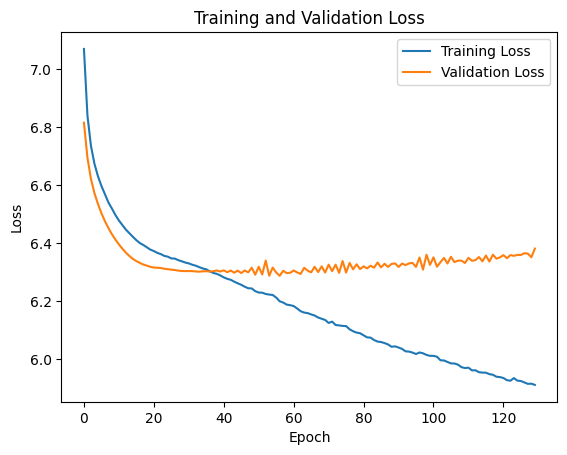

In [32]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')+
plt.legend()
plt.show()